In [2]:
import openreview
import pandas as pd
import time
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
client = openreview.api.OpenReviewClient(
    baseurl='https://api2.openreview.net',
)
# get all submissions to NeurIPS 2024
VENUE_ID = 'NeurIPS.cc/2024/Conference'
venue_group = client.get_group(f'{VENUE_ID}')
submission_name = venue_group.content['submission_name']['value']
submissions = client.get_all_notes(invitation=f'{VENUE_ID}/-/{submission_name}', details='directReplies')

Getting V2 Notes: 100%|█████████▉| 4231/4236 [00:09<00:00, 465.99it/s]


In [4]:
all_reviews = []
for paper in submissions:
    id = paper.id
    title = paper.content['title']['value']
    primary_area = paper.content['primary_area']['value']
    keywords = paper.content['keywords']['value']
    reviews = []
    decision = None 
    for reply in paper.details['directReplies']:
        if any('Official_Review' in s for s in reply['invitations']):
            rating = reply['content']['rating']['value']
            soundness = reply['content']['soundness']['value']
            presentation = reply['content']['presentation']['value']
            contribution = reply['content']['contribution']['value']
            confidence = reply['content']['confidence']['value']
            reviewer_id = reply['signatures'][0].split('/')[-1]
            review_number = reply['number']
            reviews.append({
                'paper_id': id,
                'title': title,
                'primary_area': primary_area,
                'keywords': keywords,
                'reviewer_id': reviewer_id,
                'rating': rating,
                'soundness': soundness,
                'presentation': presentation,
                'contribution': contribution,
                'confidence': confidence,
                'review_number': review_number
            })
        if any('Decision' in s for s in reply['invitations']):
            if decision is None:
                decision = reply['content']['decision']['value']
    for review in reviews:
        review['decision'] = decision
    all_reviews.extend(reviews)


In [5]:
df = pd.DataFrame(all_reviews)


In [6]:
df.head()

,paper_id,title,primary_area,keywords,reviewer_id,rating,soundness,presentation,contribution,confidence,review_number,decision
0,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_Y88j,8,4,4,3,4,1,Accept (poster)
1,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_VH7G,7,3,3,3,3,2,Accept (poster)
2,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_JNQU,5,3,3,3,3,3,Accept (poster)
3,zzOOqD6R1b,Stress-Testing Capability Elicitation With Pas...,safety_in_machine_learning,"[LLMs, Elicitation, Fine-tuning, Sandbagging, ...",Reviewer_Vgeo,5,3,4,2,4,4,Accept (poster)
4,zxSWIdyW3A,Cooperative Hardware-Prompt Learning for Snaps...,machine_vision,"[snapshot compressive imaging, hyperpectral im...",Reviewer_aeby,5,2,2,2,3,1,Accept (poster)


In [7]:
# save as csv
df.to_csv('neurips2024_reviews.csv')

### Generate Intervals (Min + Max Score) ###

In [8]:
df = df[df.decision != 'Reject'].reset_index(drop=True)

In [9]:
df.groupby('paper_id').max().value_counts('decision')

decision
Accept (poster)       3648
Accept (spotlight)     326
Accept (oral)           61
Name: count, dtype: int64

In [35]:
ratings = df.groupby('paper_id').agg({'rating': ['max', 'mean', 'min', 'count'], 'decision': 'max'}).reset_index()
ratings.columns = ['paper_id', 'rating_max', 'rating_mean', 'rating_min', 'num_reviews', 'decision']
# rename Accept (poster) to Poster and Accept (oral) or Accept (spotlight) to Spotlight/Oral
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})
ratings['decision'].value_counts()

decision
Poster            3648
Spotlight/Oral     387
Name: count, dtype: int64

In [ ]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)


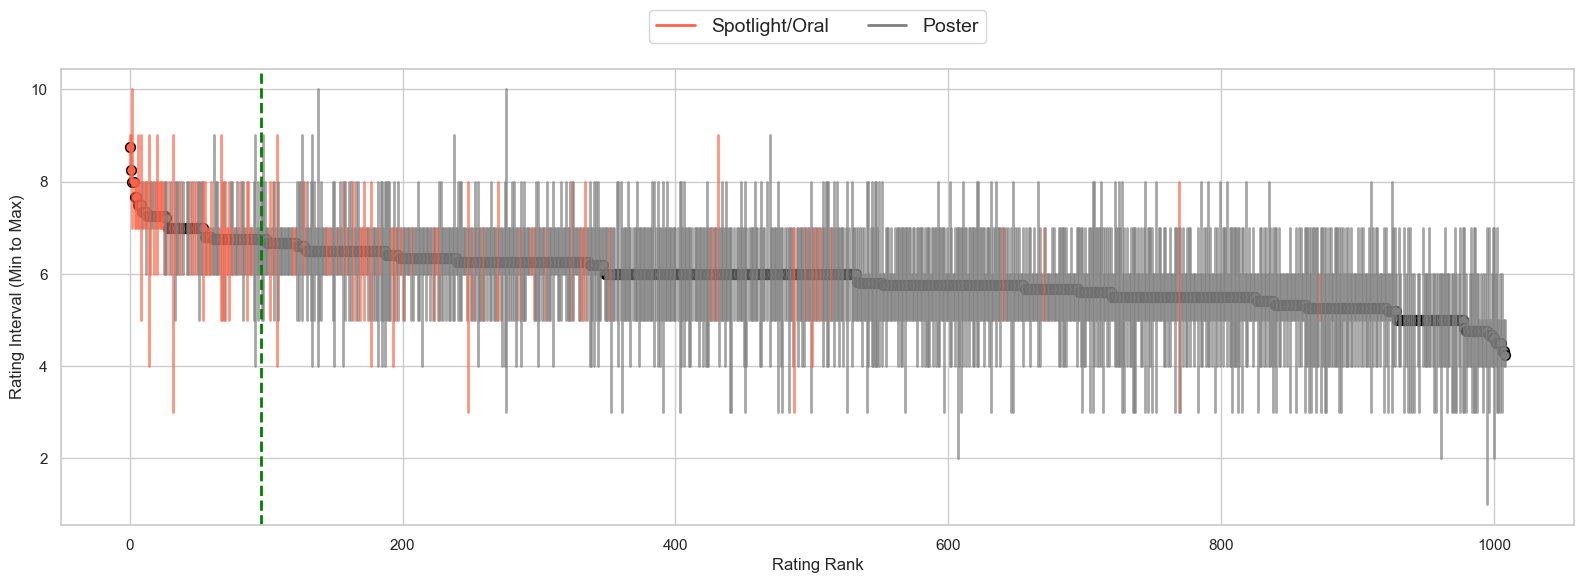

In [48]:
# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['rating_min'], row['rating_max']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['rating_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()


### Generate Intervals (Leave One Out Intervals)

In [10]:
ratings = df.groupby('paper_id').agg({'rating': list, 'decision': 'max'}).reset_index()

In [11]:
def get_interval(lst):
    means = []
    for i in range(len(lst)):
        temp_lst = lst[:i] + lst[i+1:]
        mean = 1. * sum(temp_lst) / len(temp_lst)
        means.append(mean)
    return min(means), max(means)

In [12]:
intervals = ratings['rating'].apply(get_interval)

In [24]:
ratings['rating_min'] = intervals.apply(lambda x: x[0])
ratings['rating_max'] = intervals.apply(lambda x: x[1])
ratings['rating_mean'] = ratings['rating'].apply(lambda x: sum(x) / len(x))

In [25]:
ratings

,paper_id,rating,decision,lower,upper,mean,rating_min,rating_max,rating_mean
0,00uVk06eVK,"[7, 7, 5]",Poster,6.000000,7.000000,6.333333,6.000000,7.000000,6.333333
1,01XV5Za56k,"[7, 7, 6, 5]",Poster,6.000000,6.666667,6.250000,6.000000,6.666667,6.250000
2,01qa1ZJs65,"[5, 4, 5, 7]",Poster,4.666667,5.666667,5.250000,4.666667,5.666667,5.250000
3,01s5ODIHKd,"[6, 6, 4, 6]",Poster,5.333333,6.000000,5.500000,5.333333,6.000000,5.500000
4,02CIZ8qeDc,"[5, 6, 7]",Poster,5.500000,6.500000,6.000000,5.500000,6.500000,6.000000
...,...,...,...,...,...,...,...,...,...
4030,zv4UISZzp5,"[7, 4, 4]",Poster,4.000000,5.500000,5.000000,4.000000,5.500000,5.000000
4031,zv9gYC3xgF,"[6, 6, 6, 6]",Poster,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000
4032,zw2K6LfFI9,"[6, 6, 7, 6]",Poster,6.000000,6.333333,6.250000,6.000000,6.333333,6.250000
4033,zxSWIdyW3A,"[5, 5, 6, 6]",Poster,5.333333,5.666667,5.500000,5.333333,5.666667,5.500000


In [26]:
ratings['decision'] = ratings['decision'].replace({'Accept (poster)': 'Poster', 'Accept (oral)': 'Spotlight/Oral', 'Accept (spotlight)': 'Spotlight/Oral'})

In [27]:
# subsample ratings by 25% stratifying by decision for plotting
ratings_sample = ratings.groupby('decision', group_keys=False).apply(
    lambda x: x.sample(frac=0.25, random_state=42)
).reset_index(drop=True)


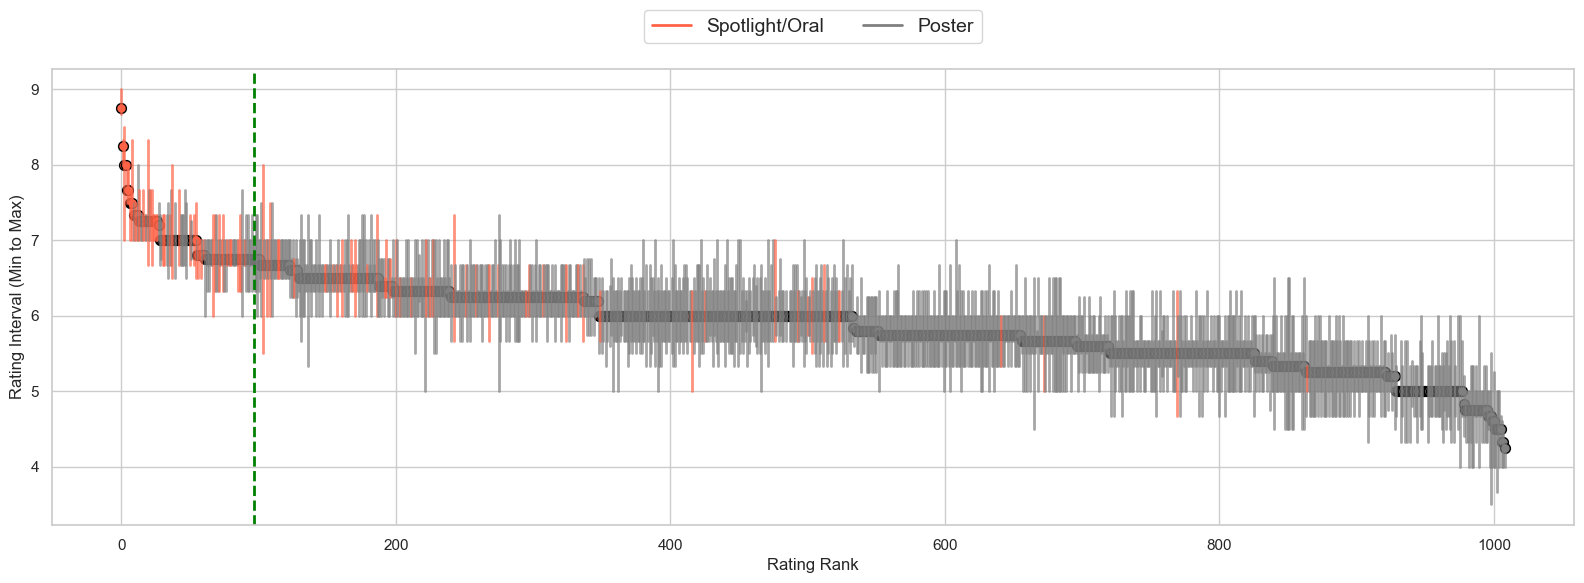

In [29]:
# order ratings by mean
ratings_sample = ratings_sample.sort_values('rating_mean', ascending=False).reset_index(drop=True)

# Set the style
sns.set(style="whitegrid")
# Set the color palette
sns.set_palette("husl")
# Define colors for each decision type
decision_colors = {
    'Spotlight/Oral': '#FF6347',  # Tomato
    'Poster': '#808080',          # Gray
}

# Plot
fig, ax = plt.subplots(figsize=(16, 6))  # Increased width from 12 to 16
for idx, row in ratings_sample.iterrows():
    color = decision_colors[row['decision']]
    ax.plot([idx, idx], [row['rating_min'], row['rating_max']], color=color, alpha=0.7, lw=2)
    ax.scatter(idx, row['rating_mean'], color=color, edgecolor='black', s=50, label=row['decision'] if row['decision'] not in ax.get_legend_handles_labels()[1] else "")

# Add legend
handles = [plt.Line2D([0], [0], color=color, lw=2, label=decision) for decision, color in decision_colors.items()]
ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.15), fontsize=14, ncol=2)

# Add vline at cutoff between # of posters and spotlights 
ax.axvline(x=ratings_sample[ratings_sample['decision'] == 'Spotlight/Oral'].shape[0] - 0.5, color='green', linestyle='--', lw=2, label='Poster/Spotlight Cutoff')

# Add labels and title
ax.set_ylabel("Rating Interval (Min to Max)")
ax.set_xlabel("Rating Rank")

plt.tight_layout()
plt.show()